In [1]:
import pathlib
import re
import string
import os
from tqdm import tqdm
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

import torch
from torch.utils.data import DataLoader, Dataset

from transformers import DataCollatorWithPadding, DataCollatorForLanguageModeling
from transformers import (
    get_linear_schedule_with_warmup,
)
from transformers import AutoModelForMaskedLM, AutoModel
from transformers import AutoTokenizer

from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ROOT_DIR = pathlib.Path().absolute()
DATA_DIR = ROOT_DIR / "data"
RANDOM_SEED = 42

In [4]:
def preprocess_text(text):
    text = text.lower()
    text = text.translate(
        str.maketrans(
            "",
            "",
            "".join(c for c in string.punctuation if c not in {",", ".", "[", "]"}),
        )
    )
    emoji_pattern = re.compile(
        "["
        "\U0001f600-\U0001f64f"
        "\U0001f300-\U0001f5ff"
        "\U0001f680-\U0001f6ff"
        "\U0001f1e0-\U0001f1ff"
        "\U00002500-\U00002bef"
        "\U00002702-\U000027b0"
        "\U0001f900-\U0001f9ff"
        "\U0001f1f2-\U0001f1f4"
        "\U0001f1e6-\U0001f1ff"
        "\U0001f194-\U0001f251"
        "\U0000203c-\U00002049"
        "\U00002b50-\U0001f251"
        "\u200d"
        "\u2640-\u2642"
        "\u2600-\u2b55"
        "\u231a-\u231b"
        "\u23cf"
        "\u23e9-\u23f3"
        "\u25aa-\u25ab"
        "\u2b05-\u2b07"
        "\u2934-\u2935"
        "\u3030"
        "\u3297-\u3299"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", text)

In [5]:
class MultiLabelDataset(Dataset):
    def __init__(self, texts, tokenizer, labels=None, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        if self.labels is not None:
            label = self.labels.iloc[idx].values.astype("float")

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )
        if self.labels is not None:
            return {
                "input_ids": encoding["input_ids"].flatten(),
                "attention_mask": encoding["attention_mask"].flatten(),
                "labels": torch.tensor(label, dtype=torch.float),
            }
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
        }

## Future pre-training
#### preparing data  

In [ ]:
model_name = "DeepPavlov/rubert-base-cased"

In [118]:
df_train = pd.read_csv(DATA_DIR/"train.csv")
df_test = pd.read_csv(DATA_DIR/"test.csv")
df_test = df_test[["text"]]
df_train = df_train[["text"]]
df = pd.concat([df_train, df_test]).reset_index()
df.text = df.text.astype("str").apply(preprocess_text)
text = df["text"]
text

0        маленький выбор товаров, хотелось бы ассортиме...
1                                                   быстро
2                         доставка постоянно задерживается
3                       наценка и ассортимент расстраивают
4        можно немного скинуть минимальную сумму заказа...
                               ...                        
13633    задержка с доставкой не даете промокод на скид...
13634    очень удобный формат сервиса и очень маленький...
13635    сумма заказа почти всегда высокая, что зачасту...
13636    часто, заказываю у вас молочную продукцию, при...
13637    изначально подкупало то, что заказ от [num] ру...
Name: text, Length: 13638, dtype: object

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name,clean_up_tokenization_spaces = True)

text_dataset = MultiLabelDataset(text, tokenizer)
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)
mlm_dataloader = DataLoader(text_dataset, batch_size=8, shuffle=True, collate_fn=data_collator)

#### Model MLM training

In [ ]:
model = AutoModelForMaskedLM.from_pretrained(model_name,trust_remote_code=True).to(device)

In [ ]:
EPOCHS = 1

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

total_steps = len(mlm_dataloader) * EPOCHS
num_warmup_steps = 0.1 * total_steps

scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps
)

model.train()
for epoch in range(EPOCHS):
    losses = []

    train_loop = tqdm(mlm_dataloader, leave=False)
    for batch in train_loop:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loop.set_description(
            f"Epoch [{epoch+1}/{EPOCHS}], Train loss {sum(losses) / len(losses):.4f}, lr: {scheduler.get_lr()[0]} "
        )
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {sum(losses)/len(mlm_dataloader)}")


In [ ]:
def make_model_contiguous(model):
    for param in model.parameters(): 
        param.data = param.data.contiguous()

make_model_contiguous(model)

In [ ]:
model.save_pretrained("pre_trained_bert")
tokenizer.save_pretrained("pre_trained_bert")

## Fine tuning  for classification
#### preparing data for classification

In [ ]:
mlc_model = "bert_multi_label_classifier"
#!mkdir {mlc_model}
pretrained_model_name = "pre_trained_bert"

pretrained_model_name = model_name # если не используется pre_trained_bert, или же при инференсе

In [13]:
data = pd.read_csv(DATA_DIR/"train.csv")
data.text = data.text.apply(preprocess_text)

replecment_dict = {
    "ASSORTMENT": "ассортимент",
    "PROMOTIONS": "акции",
    "DELIVERY": "доставка",
    "PRICE": "цена",
    "PRODUCTS_QUALITY": "качество продукции",
    "SUPPORT": "поддержка",
    "CATALOG_NAVIGATION": "навигация по каталогу",
    "PAYMENT": "оплата",
    "unknown": "",
}

data["tags"] = (
    data["tags"]
    .fillna("unknown")
    .astype("str")
    .copy()
    .apply(lambda x: x.strip("{}").split(","))
    .apply(lambda x: (", ".join(replecment_dict[i] for i in x)))
)

data["text_and_tag"] = data.apply(
    lambda x: f"теги: {x.tags}.\n отзыв: {x.text}", axis=1
)

labels = data[[f"trend_id_res{i}" for i in range(50)]]
text = data["text_and_tag"]

X_train, X_val, Y_train, Y_val = train_test_split(
    text, labels, test_size=0.15, random_state=RANDOM_SEED
)

print(X_train.shape, X_val.shape)

(3929,) (694,)


In [119]:
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)

train_dataset = MultiLabelDataset(X_train, tokenizer, Y_train)
val_dataset = MultiLabelDataset(X_val, tokenizer, Y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

#### Modelling

In [16]:
class BERTMultiLabelClassifier(torch.nn.Module):
    def __init__(self, pretrained_model_name):
        super(BERTMultiLabelClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(
            pretrained_model_name, output_hidden_states=True
        )
        self.dropout = torch.nn.Dropout(0.2)
        self.fc = torch.nn.Linear(self.bert.config.hidden_size * 4, 50)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # hidden states of all layers (13 of embeddings + 12 of transformer)
        hidden_states = outputs.hidden_states
        # concat last 4 layers
        last_four_layers = hidden_states[-4 :]
        concat_hidden_states = torch.cat(last_four_layers, dim=-1)

        pooled_output = torch.mean(concat_hidden_states, dim=1)

        pooled_output = self.dropout(pooled_output)
        logits = self.fc(pooled_output)
        return logits

In [17]:
model = BERTMultiLabelClassifier(pretrained_model_name=pretrained_model_name).to(device)
model(
    next(iter(val_loader))["input_ids"].to(device),
    next(iter(val_loader))["attention_mask"].to(device),
).shape

Some weights of BertModel were not initialized from the model checkpoint at mlm_fpt_bert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([32, 50])

In [18]:
display(model)

BERTMultiLabelClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

#### Training pipeline

In [19]:
# pw = torch.tensor((Y.shape[0] - Y.sum())/Y.sum())

criterion = torch.nn.BCEWithLogitsLoss().to(device)

In [20]:
train_acc = []
train_loss = []
val_loss = []
val_acc = []
lr_list = []

In [21]:
def train(model, EPOCHS, optimizer, scheduler=None):
    
    best_acc = -1
    for epoch in range(EPOCHS):
        running_train_loss = []
        mean_train_loss = 0
        true_answer = 0
        
        model.train()
        
        train_loop = tqdm(train_loader, leave=False)
        for batch in train_loop:
            optimizer.zero_grad()

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            
            batch_outputs = model(input_ids, attention_mask)

            loss = criterion(batch_outputs, labels)
            
            running_train_loss.append(loss.item())
            mean_train_loss = sum(running_train_loss) / len(running_train_loss)

            loss.backward()
            optimizer.step()
            
            batch_outputs = batch_outputs > 0
            true_answer += (batch_outputs == labels).all(axis=1).sum().item()
            
            if scheduler:
                scheduler.step()
                lr = scheduler.get_last_lr()
                lr_list.append(lr)
            else:
                lr = optimizer.param_groups[0]["lr"]
            
            train_loop.set_description(
                f"Epoch [{epoch+1}/{EPOCHS}], Train loss {mean_train_loss:.4f}, lr: {lr} "
            )

                
        train_loss.append(mean_train_loss)
        mean_train_acc = true_answer / len(train_loader.dataset)
        train_acc.append(mean_train_acc)

        model.eval()
        with torch.no_grad():
            running_val_loss = []
            mean_val_loss = 0
            true_answer = 0
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                batch_outputs = model(input_ids, attention_mask)

                loss = criterion(batch_outputs, labels)
                running_val_loss.append(loss.item())
                mean_val_loss = sum(running_val_loss) / len(running_val_loss)
                
                batch_outputs = (batch_outputs > 0).float()
                true_answer += (batch_outputs == labels).all(axis=1).sum().item()
                
        val_loss.append(mean_val_loss)
        mean_val_acc = true_answer / len(val_loader.dataset)
        val_acc.append(mean_val_acc)
        print(
            f"Epoch [{epoch+1}/{EPOCHS}], Train loss: {mean_train_loss:.4f}, Val loss: {mean_val_loss:.4f}, Train Accuricy {mean_train_acc:.4f}, Val Accuricy {mean_val_acc:.4f}, lr {lr}"
        )

        if best_acc == -1:
            best_acc = mean_val_acc

        if best_acc < mean_val_acc:
            best_acc = mean_val_acc

            torch.save(
                model.state_dict(),
                os.path.join(mlc_model, f"model_state_epoch_{epoch+1}.pt"),
            )
            print(f"Saved: model_state_epoch_{epoch+1}.pt Val loss {mean_val_acc:.4f}")

#### Training only new initialized layers

In [23]:
EPOCHS = 2
lr = 1e-4

params = []
names_of_train_params = [
    "bert.pooler.dense.bias",
    "bert.pooler.dense.weight",
]

for name, param in model.named_parameters():
    if "fc" in name or name in names_of_train_params:
        params.append({"params": param, "lr": lr})
    else:
        param.requires_grad = False

optimizer = torch.optim.AdamW(params)
train(model, EPOCHS, optimizer)

Epoch [1/1], Train loss: 0.0968, Val loss: 0.0842, Train Accuricy 0.0239, Val Accuricy 0.0692, lr 0.0001


#### Training fully model

In [24]:
EPOCHS = 6
lr = 5e-5

for name, param in model.named_parameters():
    param.requires_grad = True
    
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

total_steps = len(train_loader) * EPOCHS
num_warmup_steps = 0.1 * total_steps
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps
)

train(model, EPOCHS, optimizer,scheduler)

Epoch [1/6], Train loss: 0.0711, Val loss: 0.0488, Train Accuricy 0.2726, Val Accuricy 0.4467, lr [4.6296296296296294e-05]


Epoch [2/6], Train loss: 0.0450, Val loss: 0.0418, Train Accuricy 0.4821, Val Accuricy 0.5101, lr [3.7037037037037037e-05]
Saved: model_state_epoch_2.pt Val loss 0.5101


Epoch [3/6], Train loss: 0.0313, Val loss: 0.0415, Train Accuricy 0.6129, Val Accuricy 0.5216, lr [2.7777777777777776e-05]
Saved: model_state_epoch_3.pt Val loss 0.5216


Epoch [4/6], Train loss: 0.0216, Val loss: 0.0406, Train Accuricy 0.7249, Val Accuricy 0.5461, lr [1.8518518518518518e-05]
Saved: model_state_epoch_4.pt Val loss 0.5461


Epoch [5/6], Train loss: 0.0154, Val loss: 0.0413, Train Accuricy 0.8132, Val Accuricy 0.5504, lr [9.259259259259259e-06]
Saved: model_state_epoch_5.pt Val loss 0.5504


Epoch [6/6], Train loss: 0.0123, Val loss: 0.0416, Train Accuricy 0.8735, Val Accuricy 0.5562, lr [0.0]
Saved: model_state_epoch_6.pt Val loss 0.5562


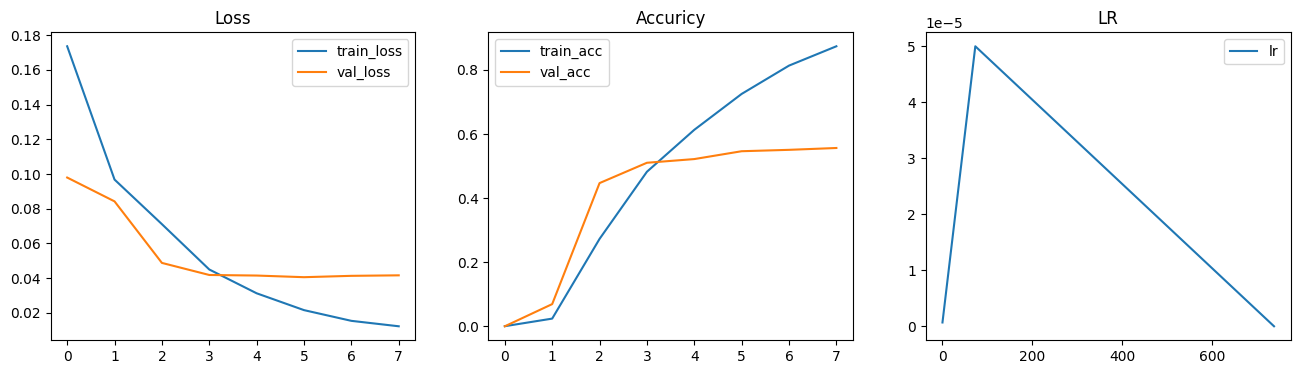

In [99]:
import matplotlib.pyplot as plt
%matplotlib inline
figure, axis = plt.subplots(1, 3,figsize=(16, 4))

axis[0].plot(train_loss)
axis[0].plot(val_loss)
axis[0].legend(["train_loss", "val_loss"])
axis[0].set_title("Loss")

axis[1].plot(train_acc)
axis[1].plot(val_acc)
axis[1].legend(["train_acc", "val_acc"])
axis[1].set_title("Accuricy")

axis[2].set_title("LR")
axis[2].plot(lr_list)
axis[2].legend(["lr"])
plt.show()

previos best

{'f1': 0.7427635172037138, 'roc_auc': 0.8883979600988988, 'accuracy': 0.5706051873198847}

## Validation

In [123]:
def multi_label_metrics(predictions, labels):
    f1_micro_average = f1_score(y_true=labels, y_pred=predictions, average="micro")
    roc_auc = roc_auc_score(labels, predictions, average="micro")
    accuracy = accuracy_score(labels, predictions)
    return {"f1": f1_micro_average, "roc_auc": roc_auc, "accuracy": accuracy}

def validation(loader, model):
    model.eval()
    labels = []
    preds = []
    outs = []
    with torch.no_grad():
        for d in loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            label = d["labels"].to(device)
            output = model(input_ids, attention_mask)
            pred = (output > 0).float()
            labels.append(label.cpu().numpy())
            preds.append(pred.cpu().numpy())
            outs.append(output.cpu().numpy())
    preds = np.vstack(preds)
    labels = np.vstack(labels)
    outs = np.vstack(outs)
    print(multi_label_metrics(labels, preds))
    return labels, outs


def find_best_treshold(labels, outs):
    max_acc = 0
    treshold_max_acc = 0
    outs = torch.sigmoid(torch.tensor(np.vstack(outs)))
    for treshold in np.arange(0.7, 0.1, -0.05):
        preds = outs > treshold
        metrics = multi_label_metrics(preds, labels)
        print(
            f"Treshold: {treshold:.2f} | Accuracy: {metrics['accuracy']:.4f} | F1: {metrics['f1']:.4f} | ROC AUC: {metrics['roc_auc']:.4f}"
        )

        if metrics["accuracy"] > max_acc:
            max_acc = metrics["accuracy"]
            treshold_max_acc = treshold
    return {"best_treshold": treshold_max_acc, "accuracy": max_acc}

#не даёт нечего т.к. модел переобучень на трейне а валидационная выборка слишком мала чтобы корректно подобрать пороги
def find_best_treshold_for_each_class(labels,outputs):
    #отделний порог для каждого класса
    tresholds = np.zeros(shape=(50)) + 0.5
    best_acc = ((outputs[:,:] > 0) == labels[:,:]).sum(axis = 0)/labels.shape[0]
    
    outputs = torch.sigmoid(torch.tensor(np.vstack(outputs)))
    for label in range(0,50):
        for t in np.arange(0.7, 0., -0.05):
            label_acc = (((outputs[:,label] > t) == labels[:,label]).sum(axis = 0))/labels.shape[0]
            if label_acc > best_acc[label]:
                tresholds[label] = t
    return torch.tensor(tresholds)

In [124]:
val_labels, val_outputs = validation(val_loader, model)
find_best_treshold(val_labels, val_outputs)

Treshold: 0.70 | Accuracy: 0.5231 | F1: 0.7136 | ROC AUC: 0.8057
Treshold: 0.65 | Accuracy: 0.5360 | F1: 0.7248 | ROC AUC: 0.8169
Treshold: 0.60 | Accuracy: 0.5432 | F1: 0.7291 | ROC AUC: 0.8249
Treshold: 0.55 | Accuracy: 0.5476 | F1: 0.7330 | ROC AUC: 0.8354
Treshold: 0.50 | Accuracy: 0.5504 | F1: 0.7393 | ROC AUC: 0.8421
Treshold: 0.45 | Accuracy: 0.5562 | F1: 0.7437 | ROC AUC: 0.8506
Treshold: 0.40 | Accuracy: 0.5605 | F1: 0.7504 | ROC AUC: 0.8622
Treshold: 0.35 | Accuracy: 0.5605 | F1: 0.7500 | ROC AUC: 0.8696
Treshold: 0.30 | Accuracy: 0.5418 | F1: 0.7401 | ROC AUC: 0.8721
Treshold: 0.25 | Accuracy: 0.5288 | F1: 0.7319 | ROC AUC: 0.8787
Treshold: 0.20 | Accuracy: 0.4928 | F1: 0.7221 | ROC AUC: 0.8882
Treshold: 0.15 | Accuracy: 0.4597 | F1: 0.7124 | ROC AUC: 0.9025


{'best_treshold': 0.3999999999999997, 'accuracy': 0.5605187319884726}

## Inferance

In [ ]:
#загрузка модели из гугл драйв
!pip install gdown
!gdown --no-check-certificate --folder https://drive.google.com/drive/folders/1-PsAAfBYC3QfHjcYVf2IZtK7eMBpG_V3?usp=drive_link

In [ ]:
model.load_state_dict(torch.load(os.path.join(mlc_model , "model_state_epoch_5.pt")))

In [79]:
#подготовка тестових даннsх
test = pd.read_csv("test.csv")
test["text"] = test["text"].astype("str").copy()

test.text = test.text.apply(preprocess_text)
test["tags"] = (
    test["tags"]
    .fillna("unknown")
    .astype("str")
    .copy()
    .apply(lambda x: x.strip("{}").split(","))
    .apply(lambda x: (", ".join(replecment_dict[i] for i in x)))
)
test["text_and_tag"] = test.apply(
    lambda x: f"теги: {x.tags}.\n отзыв: {x.text}", axis=1
)
text = test["text_and_tag"]
text

0       теги: доставка.\n отзыв: последнее время думаю...
1       теги: цена, доставка, ассортимент.\n отзыв: це...
2       теги: навигация по каталогу, ассортимент, дост...
3         теги: доставка.\n отзыв: ужасно долгая доставка
4       теги: ассортимент, акции.\n отзыв: добрый вече...
                              ...                        
9010    теги: цена, поддержка, доставка.\n отзыв: заде...
9011    теги: цена, качество продукции, ассортимент.\n...
9012    теги: оплата, ассортимент, доставка.\n отзыв: ...
9013    теги: качество продукции, поддержка, доставка....
9014    теги: ассортимент, цена, акции, доставка.\n от...
Name: text_and_tag, Length: 9015, dtype: object

In [28]:
test_dataset = MultiLabelDataset(text, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=64)

In [82]:
def predict(model,loader):
    model.eval()
    preds = []
    raw_outs = []
    with torch.no_grad():
        for d in loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            output = model(input_ids, attention_mask)
            pred = (output > 0).float()

            preds.append(pred.cpu().numpy())
            raw_outs.append(output.cpu().numpy())

    return np.vstack(preds).astype("int"), np.vstack(raw_outs)

def create_target_row(row):
    return " ".join([str(i - 1) for i, val in enumerate(row) if val == 1 and i != 0])

def to_sub_format(preds,test = test):
    res = pd.DataFrame(
        np.hstack([test["index"].values.reshape(test.shape[0], 1), preds]),
        columns=["index"] + [f"trend_id_res{i}" for i in range(50)],
    )
    res["target"] = res.apply(create_target_row, axis=1)
    res.drop([f"trend_id_res{i}" for i in range(50)], axis=1, inplace=True)

    assert res.shape == (9015, 2)
    res.to_csv(f"submission.csv", index=False)
    sub = pd.read_csv(f"submission.csv")
    return sub

def fillnan(preds,outs):
#заливает нани менее уверенными значениями, там где уверенность совсем мало заливает 19
    for t in [0.45, 0.4, 0.35]:
        pred_t = (torch.sigmoid(torch.tensor(np.vstack(outs))) > t).numpy().astype("int")
        sub_middle = pd.DataFrame(
            np.hstack([test["index"].values.reshape(test.shape[0], 1), pred_t]),
            columns=["index"] + [f"trend_id_res{i}" for i in range(50)],
        )
        sub_middle["target"] = sub_middle.apply(create_target_row, axis=1)
        sub_middle.drop([f"trend_id_res{i}" for i in range(50)], axis=1, inplace=True)
        assert sub_middle.shape == (9015, 2)
        
        sub_middle.to_csv(f"middle.csv", index=False)
        sub_middle = pd.read_csv(f"middle.csv")
        preds["target"] = preds["target"].fillna(sub_middle['target'])
        print(f"t: {t:.4f} | Nones: {(pred_t.sum(axis=1) == 0).sum()}")
    preds["target"] = preds["target"].fillna(19)
    
    return preds

In [91]:
test_preds, test_raw = predict(model,test_loader)
assert test_preds.shape == (9015, 50)
print("Nans ",(test_preds.sum(axis=1) == 0).sum())

Nans  766


In [98]:
sub = to_sub_format(test_preds)
sub = fillnan(sub,test_raw)

sub.to_csv("submission_filled.csv", index=False)
pd.read_csv(f"submission_filled.csv")

t: 0.4500 | Nones: 646
t: 0.4000 | Nones: 534
t: 0.3500 | Nones: 439


,index,target
0,3135,1 2 12
1,4655,12
2,22118,2 35
3,23511,0
4,45,18
...,...,...
9010,3523,37
9011,24925,23 28
9012,6327,8
9013,530,15
